## Importamos las libreías necesarias

In [1]:
# Libraries for data manipulation
import pandas as pd
import numpy as np

# Libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport  # py -3.9 -m pip install pandas-profiling

# Libraries for machine learning
from sklearn import (feature_selection, 
                    linear_model, 
                    model_selection, 
                    preprocessing,
                    decomposition,
                    metrics,
                    impute,
                    pipeline,
                    compose,
                    )

# Feature engineering
from featurewiz import featurewiz
import feather

Imported 0.2.02 version. Select nrows to a small number when running on huge datasets.
output = featurewiz(dataname, target, corr_limit=0.90, verbose=2, sep=',', 
		header=0, test_data='',feature_engg='', category_encoders='',
		dask_xgboost_flag=False, nrows=None, skip_sulov=False)
Create new features via 'feature_engg' flag : ['interactions','groupby','target']



In [2]:
CREATE_REPORT = True  # Si ya se ha creado el reporte, no es necesario volver a crearlo

## Cargamos los datos

In [3]:
FILENAME = "train"
df = pd.read_csv(f"data/{FILENAME}.csv")
# Si una columna tiene menos de `threshold` valores únicos se considera categórica
threshold = 1000
df = df.apply(lambda x: x.astype("category") if x.dtype == "object" and len(x.unique()) < threshold else x)
df = df.convert_dtypes()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13184 entries, 0 to 13183
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_id           13184 non-null  Int64  
 1   song_name         13184 non-null  string 
 2   song_popularity   13184 non-null  Int64  
 3   song_duration_ms  13184 non-null  Int64  
 4   acousticness      13184 non-null  Float64
 5   danceability      13184 non-null  Float64
 6   energy            13184 non-null  Float64
 7   instrumentalness  13184 non-null  Float64
 8   key               13184 non-null  Int64  
 9   liveness          13184 non-null  Float64
 10  loudness          13184 non-null  Float64
 11  audio_mode        13184 non-null  Int64  
 12  speechiness       13184 non-null  Float64
 13  tempo             13184 non-null  Float64
 14  time_signature    13184 non-null  Int64  
 15  audio_valence     13184 non-null  Float64
dtypes: Float64(9), Int64(6), string(1)
memor

### Generamos el pandas-profile

In [4]:
if CREATE_REPORT:
    profile = ProfileReport(df, infer_dtypes=False, progress_bar=True, minimal=False)
    profile.to_file(f"reports/{FILENAME}_report.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 21.74it/s]


### Creamos una tabla con la información básica de cada variable

Crear una tabla con la información básica de cada variable nos permite hacernos una idea de cómo debemos tratar los datos para resolver el problema.

La tabla contiene las siguientes columnas:
* `variable`: nombre de la tabla de la que procede la columna.
* `tipo`: tipo de la columna.
* `max`: Si la columna es numérica, el valor máximo observado. Si es categórica se deja vacío.
* `min`: Si la columna es numérica, el valor mínimo observado. Si es categórica se deja vacío.
* `mean`: Si la columna es numérica, la media. Si es categórica, el valor más común.
* `25%, 50%, 75%`: Los respectivos percentiles de las variables númericas.
* `mode`: El valor que más se repite en cada columna.
* `descripcion`: Descripción de la columna

Con el siguiente programa creamos una primera versión del excel a la que luego se le podrá añadir información de manera manual (como los comentarios adicionales)

In [6]:
base = df.describe().T.drop("count", axis=1).reset_index().rename(columns={"index": "variable"})
most_repeated = df.mode().dropna().transpose().reset_index().rename({"index": "variable", 0: "mode"}, axis=1)
base = base.merge(most_repeated, how='right', on='variable')
# print(base.to_markdown())
# base.to_csv("data/meta_info.csv", index=False)

La tabla queda de la siguiente manera:

|    | variable         |           mean |          std |          min |          25% |            50% |            75% |             max | mode                |
|---:|:-----------------|---------------:|-------------:|-------------:|-------------:|---------------:|---------------:|----------------:|:--------------------|
|  0 | song_id          |   9397.54      |  5443.03     |     0        |   4690.75    |   9406         |  14090.5       | 18832           | 0                   |
|  1 | song_name        |    nan         |   nan        |   nan        |    nan       |    nan         |    nan         |   nan           | Better              |
|  2 | song_popularity  |     53.0719    |    21.7697   |     0        |     40       |     56         |     69         |   100           | 58                  |
|  3 | song_duration_ms | 218514         | 60074.8      | 12000        | 184876       | 211794         | 243160         |     1.79935e+06 | 165000              |
|  4 | acousticness     |      0.258629  |     0.288602 |     1.02e-06 |      0.0251  |      0.132     |      0.422     |     0.996       | 0.13                |
|  5 | danceability     |      0.633784  |     0.155838 |     0        |      0.534   |      0.646     |      0.748     |     0.987       | 0.657               |
|  6 | energy           |      0.64565   |     0.214098 |     0.00107  |      0.512   |      0.6745    |      0.816     |     0.997       | 0.7040000000000001  |
|  7 | instrumentalness |      0.0770633 |     0.220458 |     0        |      0       |      1.085e-05 |      0.0025325 |     0.997       | 0.0                 |
|  8 | key              |      5.26009   |     3.61606  |     0        |      2       |      5         |      8         |    11           | 1                   |
|  9 | liveness         |      0.178801  |     0.143662 |     0.0109   |      0.0927  |      0.121     |      0.22      |     0.986       | 0.108               |
| 10 | loudness         |     -7.44523   |     3.84463  |   -38.768    |     -9.03125 |     -6.5505    |     -4.897     |     1.585       | -5.9910000000000005 |
| 11 | audio_mode       |      0.628186  |     0.483308 |     0        |      0       |      1         |      1         |     1           | 1                   |
| 12 | speechiness      |      0.101205  |     0.10401  |     0        |      0.0378  |      0.0553    |      0.117     |     0.94        | 0.032               |
| 13 | tempo            |    121.008     |    28.6638   |     0        |     98.8705  |    120.013     |    139.934     |   214.686       | 120.013             |
| 14 | time_signature   |      3.96041   |     0.298589 |     0        |      4       |      4         |      4         |     5           | 4                   |
| 15 | audio_valence    |      0.528415  |     0.246403 |     0        |      0.332   |      0.528     |      0.728     |     0.984       | 0.961  

Podemos ver que todas las características a excepción del nombre de la canción son númericas. Pasemos ahora a analizar cada una de ellas de manera más detallada.

Una de las observaciones adicionales que podemos hacer es que no hay valores nulos.

### Análisis de correlaciones

Antes que nada realizamos un análisis preeliminar de correlaciones.

In [7]:
def get_high_correlated_cols(df, threshold=0.95):
    """Returns a dict of highly correlated columns and the correlation from a dataframe."""
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    high_correlated_columns_pairs_and_value = {}
    for column in upper.columns:
        for index in upper.index:
            if upper.loc[index, column] > threshold:
                high_correlated_columns_pairs_and_value[(column, index)] = upper.loc[index, column]
    return high_correlated_columns_pairs_and_value

En cuanto a la presencia de valores repetidos, podemos observar que la columna `time_signature` presenta más de un 94% de datos iguales.

In [8]:
correlation = get_high_correlated_cols(df, threshold=0.3)
correlation

{('energy', 'acousticness'): 0.6604573163017611,
 ('loudness', 'acousticness'): 0.5602835002269761,
 ('loudness', 'energy'): 0.7597482191864439,
 ('loudness', 'instrumentalness'): 0.3891167411364504,
 ('audio_valence', 'danceability'): 0.3328347482231799,
 ('audio_valence', 'energy'): 0.31905923971135597}

Analizando las correlaciones obtenidas podemos ver que las columnas `loudness` y `energy`, tal y como nos avisaba la descripción, se encuentran altamente correlacionadas. Por tanto, podemos prescendir de una de las dos ya que la información que aportan es muy similar. Hemos decidido quedarnos con las columna `energy` y descartar `loudness` debido a que por la descripción parece más interesante esta columna.

## Feature Engineering

Vamos a hacer uso de la librería `featurewiz`. Esta librería nos permite crear de manera automática nuevas variables de las que luego se seleccionarán las mejores. 

Antes que nada vamos a eliminar las variables que no son númericas:
* `song_id`: No aporta información al ser un identificador único
* `song_name`: Esta variable se incluirá más adelante sustituyendo los valores por su frecuencia. No se realiza ahora esta sustitución para evitar el *data leakage*. Puesto que nuestra idea es realizar *cross validation*, si hiciesemos ahora esta conversión se estaría teniendo en cuenta los datos de validación a la hora de hacer la conversión.

Las variables `loudness` y `energy` dejamos que las descarte el propio método de selección de características.

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
Correlation Limit = 0.7
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Multi_Classification problem ####
    Loaded train data. Shape = (13184, 14)
#### Single_Label Multi_Classification problem ####
No test data filename given...
Classifying features using a random sample of 10000 rows from dataset...
#### Single_Label Multi_Classification problem ####
    loading a random sample of 10000 rows into pandas for EDA
#######################################################################################
###############

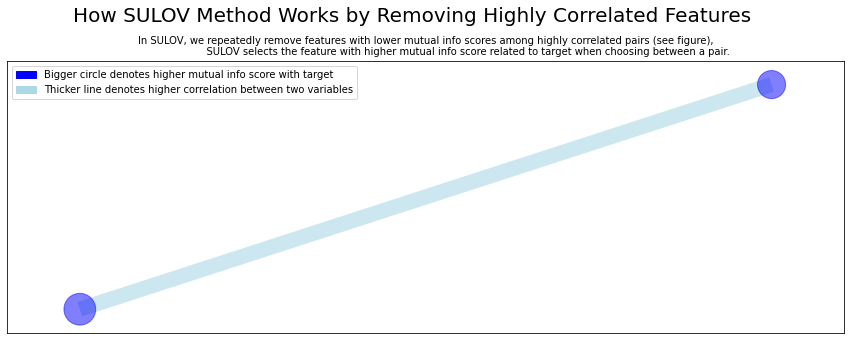

Time taken for SULOV method = 1 seconds
    Adding 0 categorical variables to reduced numeric variables  of 12
Final list of selected 12 vars after SULOV = ['acousticness', 'audio_mode', 'audio_valence', 'danceability', 'instrumentalness', 'key', 'liveness', 'song_duration_ms', 'speechiness', 'tempo', 'time_signature', 'loudness']
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Current number of predictors before recursive XGBoost = 12 
    Taking top 3 features per iteration...
    XGBoost version using 1.7.0 as tree method: hist
Number of booster rounds = 100
        using 12 variables...
            selecting 6 features in this iteration
            Time taken for regular XGBoost fe

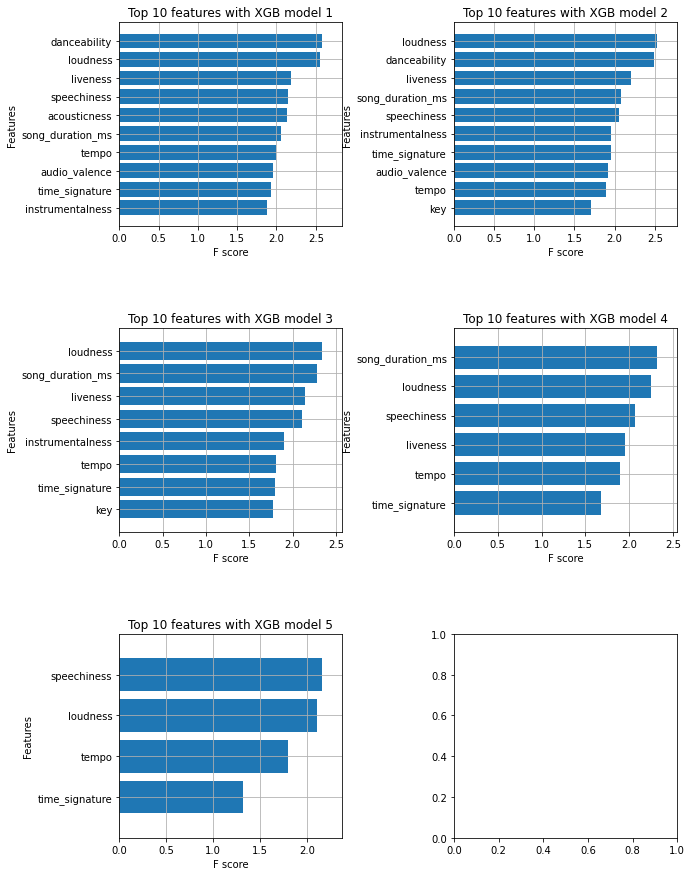

    Completed XGBoost feature selection in 1 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 6 important features:
['danceability', 'loudness', 'liveness', 'speechiness', 'acousticness', 'song_duration_ms']
Total Time taken for featurewiz selection = 100 seconds
Output contains a list of 6 important features and a train dataframe


In [12]:
df_f = df.drop(["song_id", "song_name"], axis=1)
features = featurewiz(df_f, target="song_popularity", corr_limit=0.70, verbose=2)

In [14]:
# Eliminamos la columna id
X = df.drop(columns=["song_id"])

In [15]:
target = "song_popularity"
X = df.drop(columns=[target])
y = df[target]

In [16]:
def data_engineering_pipeline(data, numeric_col_missing_threshold=0., exclude_cols=None):
    """Returns a dataframe with the data engineering pipeline applied.
    This pipeline will:
        - Convert 'category' columns to 'str' columns.
        - Create a new column "n_missing_values" with the number of missing values per row.
        - Convert missing values in 'str' columns to 'missing' string.
        - Adds columns indicating if the value was missing or not for the numeric columns.
    Args:
        data (pandas.DataFrame): The dataframe to be analyzed.
        numeric_col_missing_threshold (float): The threshold (percentage) for numeric columns to add a missing indicator.
        exclude_cols (list): The columns to be excluded from the pipeline.
    """
    exclude_cols = exclude_cols if exclude_cols is not None else []
    data = data.copy()
    data_subset = data.drop(exclude_cols, axis=1)

    # Para evitar erores convertimos las columnas categóricas a string
    data_subset = data_subset.copy().apply(lambda x: x.astype("str") if x.dtype == "category" else x)

    categorical_cols = data_subset.select_dtypes(include=["string", "object"]).columns
    numeric_cols = data_subset.select_dtypes(exclude=["string", "object", "datetime"]).columns

    # Creamos una nueva columna con el número de valores nulos por fila
    data_subset["n_missing_values"] = data_subset.isnull().sum(axis=1)

    # Creamos una categoría "missing" para los valores faltantes
    data_subset[categorical_cols] = data_subset[categorical_cols].fillna("missing")

    # Añadimos una columna por cada columna categórica que indique la frecuencia de cada valor en la columna
    for col in categorical_cols:
        data_subset[f"{col}_freq"] = data_subset[col].map(data_subset[col].value_counts(normalize=True))

    # Añadimos una columna binaria por cada columna numérica que indique si el valor es nulo o no
    for col in data_subset.select_dtypes(include="number").columns:
        if data_subset[col].isnull().mean() > numeric_col_missing_threshold:
            data_subset[f"{col}_isnull"] = data_subset[col].isnull().astype(int)
    
    data = data[exclude_cols].merge(data_subset, how="left", left_index=True, right_index=True)
    
    return data.copy()

In [17]:
X_1 = data_engineering_pipeline(X, exclude_cols=["song_name"])
X_1.head()

,song_name,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,n_missing_values
0,Maneater - Radio Edit,270946,0.0153,0.728,0.518,0.000042,11,0.103,-11.114,0,0.038,88.708,4,0.833,0
1,Better Off Alone,192835,0.0155,0.903,0.498,0.000008,8,0.105,-6.379,1,0.108,121.974,4,0.439,0
2,Song That I Heard,237666,0.773,0.267,0.356,0.00176,8,0.167,-12.103,1,0.0317,92.272,4,0.314,0
3,Zumba,263973,0.00205,0.729,0.894,0.021,5,0.128,-3.494,1,0.0397,124.992,4,0.832,0
4,Bumper To Bumper,225933,0.148,0.771,0.735,0.0,5,0.288,-9.162,0,0.116,119.983,4,0.385,0


## Preprocesado

In [18]:
cat_cols = X_1.select_dtypes(include=["category", "string", "object"]).columns
num_cols = X_1.select_dtypes(exclude=["category", "string", "object"]).columns

Transformación a variables numéricas

In [19]:
numeric_transformer = pipeline.Pipeline(steps=[
    ("imputer", impute.SimpleImputer(strategy="mean")),
    ("scaler", preprocessing.StandardScaler())])

Transformación en las variables categóticas

In [20]:
categorical_transformer = pipeline.Pipeline(steps=[
    ("imputer", impute.SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", preprocessing.OneHotEncoder(handle_unknown="infrequent_if_exist", 
                                           sparse=False,
                                           min_frequency=0.05))])

Aplicamos las transformaciones

In [21]:
preprocessor = compose.ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)])

In [22]:
X_2 = preprocessor.fit_transform(X_1)
column_names = preprocessor.named_transformers_["cat"]["onehot"].get_feature_names(cat_cols)
column_names = num_cols.tolist() + column_names.tolist()
X_2 = pd.DataFrame(data=X_2, columns=column_names)
X_2.head()

,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,n_missing_values,song_name_infrequent_sklearn
0,0.872819,-0.843162,0.604600,-0.596246,-0.349384,1.587400,-0.527658,-0.954294,-1.299813,-0.607703,-1.126897,0.132607,1.236175,0.0,1.0
1,-0.427460,-0.842469,1.727602,-0.689664,-0.349538,0.757736,-0.513736,0.277339,0.769341,0.065332,0.033705,0.132607,-0.362894,0.0,1.0
2,0.318821,1.782357,-2.353706,-1.352937,-0.341590,0.757736,-0.082150,-1.211545,0.769341,-0.668277,-1.002554,0.132607,-0.870213,0.0,1.0
3,0.756742,-0.889075,0.611017,1.160025,-0.254314,-0.071929,-0.353632,1.027764,0.769341,-0.591358,0.138999,0.132607,1.232117,0.0,1.0
4,0.123507,-0.383341,0.880538,0.417347,-0.349574,-0.071929,0.760138,-0.446554,-1.299813,0.142250,-0.035758,0.132607,-0.582056,0.0,1.0


## Selección de características

Para realizar la selección de características vamos a utilizar varios métodos, por lo que llevaremos un recuento de cuántas veces una variable ha sido propuesta para ser eliminada por cada uno de ellos.

In [23]:
elimination_recount = {col: 0 for col in X_2.columns}

In [24]:
def update_recount(cols):
    for col in cols:
        elimination_recount[col] += 1

#### Métodos de filtro

##### Valores nulos

Este dataset no presenta valores nulos.

##### Columnas casi constantes o con varianza demasiado baja

In [25]:
def del_constant_cols(df_: pd.DataFrame, 
                      constant_threshold: float = 0.95, 
                      variance_threshold: float = 0.1, 
                      verbose: bool = True) -> pd.DataFrame:
    """Returns a dict of quasi-constant columns and the percentage of the most frequent value
    from a dataframe.
    Args:
        df_ (pandas.DataFrame): The dataframe to be analyzed.
        constant_threshold (float): The threshold for quasi-constant columns.
        variance_threshold (float): The threshold for low variance columns.
        verbose (bool): Whether to print the message with detail information about the reason of the deletion.
    :returns pandas.DataFrame
    """
    cols = []
    del_cols_constant = []
    for column in df_.columns:
        try:
            percentage = df_[column].value_counts(normalize=True).values[0]
        except IndexError:
            percentage = 0
        if percentage < constant_threshold:
            cols.append(column)
        else:
            del_cols_constant.append(column)
    df_new = df_[cols]
    num_df_ = df_new.select_dtypes(exclude=['object', 'category', 'string'])
    selector = feature_selection.VarianceThreshold(variance_threshold)
    selector.fit(num_df_)
    cat_cols = df_new.select_dtypes(include=['object', 'category', 'string']).columns
    num_cols = num_df_.columns[selector.get_support(indices=True)]
    all_cols = cat_cols.union(num_cols)
    cols_num = sorted(df_.columns.get_indexer(all_cols))
    if verbose:
        print(f'Columns deleted because of constant values: {del_cols_constant}')
        print(f'Columns deleted because of VarianceThreshold: {[col for col in num_df_.columns if col not in num_cols]}')
    return del_cols_constant + [col for col in num_df_.columns if col not in num_cols]

In [26]:
constant_cols = del_constant_cols(X_2, constant_threshold=0.9, variance_threshold=0.01)

Columns deleted because of constant values: ['time_signature', 'n_missing_values', 'song_name_infrequent_sklearn']
Columns deleted because of VarianceThreshold: []


In [27]:
X_3 = X_2.drop(constant_cols, axis=1)

In [28]:
X_3.dtypes

song_duration_ms    float64
acousticness        float64
danceability        float64
energy              float64
instrumentalness    float64
key                 float64
liveness            float64
loudness            float64
audio_mode          float64
speechiness         float64
tempo               float64
audio_valence       float64
dtype: object

##### Selección de K mejores

In [29]:
# Usamos sklearn para quedarnos con las K mejores columnas (SelectKBest)
percentage_of_colums_to_keep = 0.8
k = int(len(X_3.columns) * percentage_of_colums_to_keep)
score_func = feature_selection.f_regression
selector = feature_selection.SelectKBest(score_func=score_func, k=k)
selector.fit(X_3, y)
cols = selector.get_support(indices=True)
cols = X_3.columns[cols]
cols

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

#### Métodos de Wrapper

#### Métodos de embeding

#### PCA

In [ ]:
# We are going to use